In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
#stop_word=['ourselves','hers','between','yourself','but','again','there','about','once','during','out','very','having','with','they','own','an','be','some','for','do','its','yours','such','into','of','most','itself','other','off','is','s','am','or','who','as','from','him','each','the','themselves','until','below','are','we','these','your','his','through','don','nor','me','were','her','more','himself','this','down','should','our','their','while','above','both','up','to','ours','had','she','all','no','when','at','any','before','them','same','and','been','have','in','will','on','does','yourselves','then','that','because','what','over','why','so','can','did','not','now','under','he','you','herself','has','just','where','too','only','myself','which','those','i','after','few','whom','t','being','if','theirs','my','against','a','by','doing','it','how','further','was','here','than']

In [3]:
import nltk
import pandas as pd
import re
import string
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


# def get_keywords(row):     
#       tokens = row.split()
#       re_punc = re.compile('[%s]' % re.escape(string.punctuation))
#       tokens = [re_punc.sub('', w) for w in tokens]
#       tokens = [word for word in tokens if word.isalpha()]
#       stop_words =stop_word #set(stopwords.words('english'))
#       tokens = [w for w in tokens if w not in stop_words]
#       porter = PorterStemmer()
#       stemmed = [porter.stem(word) for word in tokens]
#       tokens = [word for word in tokens if len(word) > 1]
#       return " ".join(tokens)

In [4]:
import pandas as pd
import numpy as np


df=pd.read_csv("/content/hk_45-final_annotated_contracts_annotated1.csv")
df.head(5)

,Unnamed: 0,Sentence,Word,Tag
0,0,1,between,O
1,1,1,eden,B-PAR
2,2,1,hospital,L-PAR
3,3,1,health,L-PAR
4,4,1,services,L-PAR


In [5]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                       
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [6]:
getter = SentenceGetter(df)
sentences = getter.sentences

In [7]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 228


In [8]:
words = list(set(df["Word"].values))
words.append("ENDPAD")

In [9]:
n_words = len(words); n_words

380

In [10]:
tags = list(set(df["Tag"].values))

In [11]:
n_tags = len(tags); n_tags

14

In [12]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [13]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [14]:
X = pad_sequences(maxlen=228, sequences=X, padding="post",value=n_words - 1)

In [15]:
X

array([[314,  89, 122, ..., 379, 379, 379],
       [ 14,  33, 177, ..., 379, 379, 379],
       [ 14,   9, 201, ..., 379, 379, 379],
       ...,
       [155,  43, 281, ..., 379, 379, 379],
       [ 14, 289,  19, ..., 379, 379, 379],
       [174,  14, 197, ..., 379, 379, 379]], dtype=int32)

In [16]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [17]:
y = pad_sequences(maxlen=228, sequences=y, padding="post", value=tag2idx["O"])

In [18]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [19]:
y=np.array(y)

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional,Input


In [21]:
!pip install tf2crf

In [22]:
!pip install tensorflow-radam

  Created wheel for tensorflow-radam: filename=tensorflow_radam-0.15.0-cp36-none-any.whl size=14735 sha256=d67ba6e1ad9c928d5932133eb8e96d323c1c51ef1122ac1284a72776134d6922
  Stored in directory: /root/.cache/pip/wheels/da/7a/35/e0456209b21aa597e1143e41fe71a34b1283325dbf043581ad
Successfully built tensorflow-radam


In [23]:
from tf2crf import CRF
from keras_radam.training import RAdamOptimizer

In [ ]:
input = Input(shape=(228,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=228, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1,activation='relu'))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
model = TimeDistributed(Dense(30, activation="relu"))(model)
output = Dense(14, activation=None)(model)
crf = CRF()  # CRF layer
out = crf(output)  # output
model = Model(input, out)

In [ ]:
n_tags

14

In [ ]:
model.compile(optimizer=RAdamOptimizer(learning_rate=1e-3), loss=crf.loss, metrics=[crf.accuracy])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 228)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 228, 20)           7620      
_________________________________________________________________
bidirectional (Bidirectional (None, 228, 100)          28400     
_________________________________________________________________
time_distributed (TimeDistri (None, 228, 50)           5050      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 228, 30)           1530      
_________________________________________________________________
dense_2 (Dense)              (None, 228, 14)           434       
_________________________________________________________________
crf (CRF)                    (None, 228, 14)          

In [ ]:
history = model.fit(X, y, batch_size=10, epochs=100, verbose=1)

Epoch 1/100
5/5 [==============================] - 11s 2s/step - loss: 367.0518 - accuracy: 0.9767
Epoch 2/100
5/5 [==============================] - 11s 2s/step - loss: 75.3570 - accuracy: 0.9767
Epoch 3/100
5/5 [==============================] - 10s 2s/step - loss: 74.9231 - accuracy: 0.9767
Epoch 4/100
5/5 [==============================] - 10s 2s/step - loss: 74.2899 - accuracy: 0.9767
Epoch 5/100
5/5 [==============================] - 11s 2s/step - loss: 73.5037 - accuracy: 0.9767
Epoch 6/100
5/5 [==============================] - 10s 2s/step - loss: 72.5769 - accuracy: 0.9767
Epoch 7/100
5/5 [==============================] - 10s 2s/step - loss: 71.4990 - accuracy: 0.9767
Epoch 8/100
5/5 [==============================] - 11s 2s/step - loss: 70.2847 - accuracy: 0.9767
Epoch 9/100
5/5 [==============================] - 10s 2s/step - loss: 68.9386 - accuracy: 0.9767
Epoch 10/100
5/5 [==============================] - 11s 2s/step - loss: 67.4220 - accuracy: 0.9767
Epoch 11/100
5/5 [

KeyboardInterrupt: ignored

In [ ]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
test_sentence="my name is ambuje gupta"
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in tokenize(test_sentence)]],
                            padding="post", value=n_words-1, maxlen=228)

In [ ]:
# between eden hospital health services corporation and eden medical center



In [ ]:
p=model.predict(np.array([x_test_sent[0]]))

In [ ]:
p

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [ ]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
test_sentence="my name is ambuje gupta"
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in tokenize(test_sentence)]],
                            padding="post", value=n_words-1, maxlen=228)
p=model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(tokenize(test_sentence), p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))

Word           ||Prediction
my             : O    
name           : O    
is             : O    
ambuje         : O    
gupta          : O    


In [ ]:
z

array([[[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [ ]:
X.shape

(45, 228)

In [ ]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [ ]:
a='my name is ambuje'

In [ ]:
[[word2idx[w[0]] for w in s] for s in a]

KeyError: ignored

In [ ]:
[word2idx[w[0]] for w in a]

KeyError: ignored

In [ ]:
word2idx['my']

KeyError: ignored

In [ ]:
sentences

[[('between', 'O'),
  ('eden', 'B-PAR'),
  ('hospital', 'I-PAR'),
  ('health', 'I-PAR'),
  ('services', 'I-PAR'),
  ('corporation', 'L-PAR'),
  ('and', 'O'),
  ('eden', 'B-PAR'),
  ('medical', 'I-PAR'),
  ('center', 'L-PAR')],
 [('this', 'O'),
  ('restated', 'O'),
  ('management', 'O'),
  ('services', 'O'),
  ('agreement', 'O'),
  ('(', 'O'),
  ('11agreement', 'O'),
  ('")', 'O'),
  ('is', 'O'),
  ('entered', 'O'),
  ('by', 'O'),
  ('and', 'O'),
  ('between', 'O'),
  ('eden', 'B-PAR'),
  ('hospital', 'I-PAR'),
  ('health', 'I-PAR'),
  ('services', 'I-PAR'),
  ('corporation', 'L-PAR'),
  (',', 'O'),
  ('a', 'O'),
  ('california', 'O'),
  ('nonprofit', 'O'),
  ('mutual', 'O'),
  ('benefit', 'O'),
  ('corporation', 'O'),
  ('("', 'O'),
  ('health', 'O'),
  ('services', 'O'),
  ('corporation', 'O'),
  ('")', 'O'),
  (',', 'O'),
  ('and', 'O'),
  ('eden', 'B-PAR'),
  ('medical', 'I-PAR'),
  ('center', 'L-PAR'),
  (',', 'O'),
  ('a', 'O'),
  ('california', 'O'),
  ('nonprofit', 'O'),
  ('pub

In [ ]:
a = pad_sequences(maxlen=228, sequences=a, padding="post",value=n_words - 1)

ValueError: ignored

In [ ]:
a

'my name is ambuje'

In [ ]:
X

array([[ 64, 112, 313, ..., 379, 379, 379],
       [ 42, 148,  55, ..., 379, 379, 379],
       [ 42, 248, 216, ..., 379, 379, 379],
       ...,
       [161,  69, 237, ..., 379, 379, 379],
       [ 42,  28, 334, ..., 379, 379, 379],
       [181,  42, 257, ..., 379, 379, 379]], dtype=int32)

In [ ]:

# Link for the dataset ==>> https://takeafile.com/?f=topobugawe (Save karlena bs ikbaar hi download hoga is link se :) )

In [ ]:
#!unzip code_mix_final.csv.zip

In [24]:
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,Embedding
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np

In [ ]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import numpy as np

tokenizer = Tokenizer()
full_text = (df['Word'].values)
tokenizer.fit_on_texts(full_text)


X_train, X_test, y_train, y_test = train_test_split(df['Word'],np.array(y),test_size = .2)

KeyError: ignored

In [ ]:
X = tokenizer.texts_to_sequences(df['Word'])


In [ ]:
max_len = 300
#using default pre padding. if phrase length is more than 40, it is truncated from starting.


In [ ]:
X = pad_sequences(maxlen=242, sequences=X, padding="post",value=n_words - 1)

In [ ]:
X

array([[ 27, 379, 379, ..., 379, 379, 379],
       [ 84, 379, 379, ..., 379, 379, 379],
       [ 20, 379, 379, ..., 379, 379, 379],
       ...,
       [  2, 379, 379, ..., 379, 379, 379],
       [114, 379, 379, ..., 379, 379, 379],
       [379, 379, 379, ..., 379, 379, 379]], dtype=int32)

In [25]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

--2020-08-18 01:37:15--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  49.9MB/s    in 29s     

2020-08-18 01:37:45 (49.8 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [26]:
!unzip 'crawl-300d-2M.vec.zip'

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [27]:
embedding_path = "crawl-300d-2M.vec"

In [28]:
len(df.Word.unique())

379

In [29]:
max_features = 379 #using all unique words
embedding_dim = 300
num_classes = 14
batch_size = 1024

In [30]:
import numpy as np
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path,encoding='utf8'))

In [31]:
word_index = word2idx
nb_words = len(word_index)
embedding_matrix = np.zeros((nb_words + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [32]:
X.shape

(45, 228)

In [51]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            input_length=228, mask_zero = True, weights = [embedding_matrix], trainable = False)

In [52]:
input = Input(shape=(228,))
model = embedding_layer(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1,activation='relu'))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
model = TimeDistributed(Dense(30, activation="relu"))(model)
output = Dense(14, activation=None)(model)
crf = CRF()  # CRF layer
out = crf(output)  # output
model = Model(input, out)

In [53]:
model.compile(optimizer=RAdamOptimizer(learning_rate=1e-3), loss=crf.loss, metrics=[crf.accuracy])
model.summary()


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 228)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 228, 300)          114300    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 228, 100)          140400    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 228, 50)           5050      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 228, 30)           1530      
_________________________________________________________________
dense_8 (Dense)              (None, 228, 14)           434       
_________________________________________________________________
crf_2 (CRF)                  (None, 228, 14)          

In [54]:
history = model.fit(X, y, batch_size=10, epochs=100, verbose=1)

Epoch 1/100
5/5 [==============================] - 6s 1s/step - loss: 369.9686 - accuracy: 0.7618
Epoch 2/100
5/5 [==============================] - 6s 1s/step - loss: 60.1884 - accuracy: 0.9767
Epoch 3/100
5/5 [==============================] - 6s 1s/step - loss: 59.7779 - accuracy: 0.9767
Epoch 4/100
5/5 [==============================] - 6s 1s/step - loss: 59.2091 - accuracy: 0.9767
Epoch 5/100
5/5 [==============================] - 6s 1s/step - loss: 58.4871 - accuracy: 0.9767
Epoch 6/100
5/5 [==============================] - 7s 1s/step - loss: 57.6516 - accuracy: 0.9767
Epoch 7/100
5/5 [==============================] - 6s 1s/step - loss: 56.7180 - accuracy: 0.9767
Epoch 8/100
5/5 [==============================] - 6s 1s/step - loss: 55.7019 - accuracy: 0.9767
Epoch 9/100
5/5 [==============================] - 6s 1s/step - loss: 54.5925 - accuracy: 0.9767
Epoch 10/100
5/5 [==============================] - 6s 1s/step - loss: 53.4187 - accuracy: 0.9767
Epoch 11/100
5/5 [==========

In [63]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
test_sentence="between eden hospital health services"
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in tokenize(test_sentence)]],
                            padding="post", value=n_words-1, maxlen=228)
p=model.predict(np.array([x_test_sent[0]]))
print(p)
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(tokenize(test_sentence), p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
Word           ||Prediction
between        : O    
eden           : O    
hospital       : O    
health         : O    
services       : O    


In [56]:
df

,Unnamed: 0,Sentence,Word,Tag
0,0,1,between,O
1,1,1,eden,B-PAR
2,2,1,hospital,L-PAR
3,3,1,health,L-PAR
4,4,1,services,L-PAR
...,...,...,...,...
2090,44,45,the,O
2091,45,45,state,O
2092,46,45,of,O
2093,47,45,oregon,O


In [ ]:
# !pip install tf2crf

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM,Input, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
# from keras_contrib.layers import CRF
from tf2crf import CRF

word_embedding_size=300

# model = Sequential()
# model.add(embedding_layer)
# model.add(Bidirectional(LSTM(units=word_embedding_size, 
#                            return_sequences=True, 
#                            dropout=0.5, 
#                            recurrent_dropout=0.5, 
#                            kernel_initializer=k.initializers.he_normal())))
# model.add(LSTM(units=word_embedding_size * 2, 
#              return_sequences=True, 
#              dropout=0.5, 
#              recurrent_dropout=0.5, 
#              kernel_initializer=k.initializers.he_normal()))

# model.add(TimeDistributed(Dense(n_tags, activation="relu")))
# crf = CRF(n_tags)
# model.add(crf(model))

input = Input(shape=(228,))
# word_embedding_size = 300

# # Embedding Layer
# model = Embedding(input_dim=max_features, output_dim=word_embedding_size, input_length=max_len)(input)
model1 = Embedding(len(word_index) + 1,
                            embedding_dim,
                            input_length=228, mask_zero = True, weights = [embedding_matrix], trainable = False)(input)

# # BI-LSTM Layer
model1 = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5))(model1)
model1 = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model1)

# TimeDistributed Layer
model1 = TimeDistributed(Dense(n_tags, activation="relu"))(model1)  

# CRF Layer
crf = CRF(n_tags)

out = crf(model1)  # output
model1 = Model(input, out)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
#Optimiser 
adam =Adam(lr=0.05, beta_1=0.9, beta_2=0.999)

# Compile model
model1.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy])

model1.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 228)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 228, 300)          114300    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 228, 600)          1442400   
_________________________________________________________________
lstm_3 (LSTM)                (None, 228, 600)          2882400   
_________________________________________________________________
time_distributed_4 (TimeDist (None, 228, 14)           8414      
_________________________________________________________________
crf_2 (CRF)                  (None, 228, 14)           196       
Total params: 4,447,710
Trainable params: 4,333,410
Non-trainable params: 114,300
______________________________________

In [ ]:
# filepath="/content/drive/My Drive/Legal.AI/models/ner-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

# Fit the best model
history = model1.fit(X,y, batch_size=8, epochs=1000, verbose=1)
# plt.style.use('ggplot')

# def plot_history(history):
#     accuracy = history.history['accuracy']
#     val_accuracy = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     x = range(1, len(acc) + 1)

#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(x, acc, 'b', label='Training acc')
#     plt.plot(x, val_acc, 'r', label='Validation acc')
#     plt.title('Training and validation accuracy')
#     plt.legend()
#     plt.subplot(1, 2, 2)
#     plt.plot(x, loss, 'b', label='Training loss')
#     plt.plot(x, val_loss, 'r', label='Validation loss')
#     plt.title('Training and validation loss')
#     plt.legend()

# plot_history(history)

Epoch 1/1000
6/6 [==============================] - 20s 3s/step - loss: 12.4162 - accuracy: 0.9767
Epoch 2/1000
6/6 [==============================] - 20s 3s/step - loss: 12.4171 - accuracy: 0.9767
Epoch 3/1000
6/6 [==============================] - 20s 3s/step - loss: 12.4112 - accuracy: 0.9767
Epoch 4/1000
6/6 [==============================] - 20s 3s/step - loss: 12.4245 - accuracy: 0.9767
Epoch 5/1000
6/6 [==============================] - 20s 3s/step - loss: 12.4034 - accuracy: 0.9767
Epoch 6/1000
6/6 [==============================] - 20s 3s/step - loss: 12.4151 - accuracy: 0.9767
Epoch 7/1000
6/6 [==============================] - 19s 3s/step - loss: 12.3999 - accuracy: 0.9767
Epoch 8/1000
6/6 [==============================] - 20s 3s/step - loss: 12.4073 - accuracy: 0.9767
Epoch 9/1000
6/6 [==============================] - 20s 3s/step - loss: 12.4223 - accuracy: 0.9767
Epoch 10/1000
6/6 [==============================] - 20s 3s/step - loss: 12.4013 - accuracy: 0.9767
Epoch 11/

In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint
# import matplotlib.pyplot as plt

# #Optimiser 
# adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# # Compile model
# model.compile(optimizer='adam', loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])

# model.summary()

# # Saving the best model only
# filepath="/content/drive/My Drive/Projects/Legal.AI/models/ner-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

# # Fit the best model
# history = model.fit(X, np.array(y), batch_size=256, epochs=10, validation_split=0.2, verbose=1, callbacks=callbacks_list)

# # Plot the graph 
# plt.style.use('ggplot')

# def plot_history(history):
#     accuracy = history.history['accuracy']
#     val_accuracy = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     x = range(1, len(acc) + 1)

#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(x, acc, 'b', label='Training acc')
#     plt.plot(x, val_acc, 'r', label='Validation acc')
#     plt.title('Training and validation accuracy')
#     plt.legend()
#     plt.subplot(1, 2, 2)
#     plt.plot(x, loss, 'b', label='Training loss')
#     plt.plot(x, val_loss, 'r', label='Validation loss')
#     plt.title('Training and validation loss')
#     plt.legend()

# plot_history(history)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          4073700   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 600)          1442400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 600)          2882400   
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 14)           8414      
_________________________________________________________________
crf_1 (CRF)                  (None, 100, 14)           196       
Total params: 8,407,110
Trainable params: 8,407,110
Non-trainable params: 0
___________________________________________________

NameError: ignored

In [ ]:
# model = Sequential()
# model.add(embedding_layer)

In [ ]:
# from keras.models import Sequential
# from keras.layers.convolutional import Conv3D
# from keras.layers.convolutional_recurrent import ConvLSTM2D
# from keras.layers.normalization import BatchNormalization
# import numpy as np
# import keras
# from matplotlib import pyplot as plt
# from keras.layers import Dense, Embedding, LSTM, GRU
# from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout,Conv2D,MaxPooling2D,Conv3D,MaxPooling3D
# from keras.callbacks import ModelCheckpoint
# from tensorflow.keras import layers

In [ ]:
# from tensorflow.keras import layers
# from tensorflow.keras.layers import LSTM,Input, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
# from tf2crf import CRF
# from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# word_embedding_size=300
# model = Sequential()
# #model.add(Input(300,))
# model.add(embedding_layer) #using pre-trained embeddings
# #model.add(layers.Dropout(0.008))
# model.add(Bidirectional(LSTM(units=word_embedding_size, 
#                            return_sequences=True, 
#                            dropout=0.5, 
#                            recurrent_dropout=0.5)))

# model.add(LSTM(units=word_embedding_size * 2, 
#              return_sequences=True, 
#              dropout=0.5, 
#              recurrent_dropout=0.5))

# model.add(TimeDistributed(Dense(n_tags, activation="relu")))
# crf = CRF(n_tags)
# model.add(crf)




#model.add(LSTM(64,dropout=0.12, recurrent_dropout=0.15,return_sequences=True))                         #returning full sequence for next layer, also using recurrent output
#model.add(layers.Dropout(0.1))
# model.add(LSTM(100,dropout=0.12, recurrent_dropout=0.15,return_sequences=True))                         #returning full sequence for next layer, also using recurrent output
# model.add(layers.Dropout(0.1))
#model.add(LSTM(64,dropout=0.15, recurrent_dropout=0.12,return_sequences=False))                         #returning only last output.  
#model.add(layers.Dropout(0.1))

#model.add(Dense(512,activation='relu'))
#model.add(layers.Dropout(0.1))
# model.add(Dense(256,activation='relu')) 
# model.add(layers.Dropout(0.1)) 
# model.add(Dense(128,activation='tanh'))
# model.add(layers.Dropout(0.1))  
# model.add(Dense(64,activation='tanh'))  
# model.add(layers.Dropout(0.1))
# model.add(Dense(32,activation='relu'))
# model.add(layers.Dropout(0.1))
# model.add(Dense(16,activation='relu'))
# model.add(layers.Dropout(0.1))

#model.add(Dense(num_classes,activation='softmax'))                                                    #final output
#sgd =keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# adam =Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# # Compile model
# model.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy])

# model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          2262000   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 300, 600)          1442400   
_________________________________________________________________
lstm_28 (LSTM)               (None, 300, 600)          2882400   
_________________________________________________________________
time_distributed_11 (TimeDis (None, 300, 14)           8414      
_________________________________________________________________
crf_11 (CRF)                 (None, 300, 14)           196       
Total params: 6,595,410
Trainable params: 4,333,410
Non-trainable params: 2,262,000
_________________________________________________________________


In [ ]:
# X_train.shape

(258821, 300)

In [ ]:
# y_test.shape

(64706, 14)

In [ ]:
# filepath="/content/drive/My Drive/Projects/Legal.AI/models/ner-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

# # Fit the best model
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=256, epochs=10, verbose=1, callbacks=callbacks_list)

Epoch 1/10


ValueError: ignored

In [ ]:
# model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          2262000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 300, 64)           93440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 64)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               33280     
_________________________________________________________________
dense_3 (Dense)              (None, 14)               

In [ ]:
# #callbacks
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
# reduce_lr =  ReduceLROnPlateau(monitor='val_loss',verbose=1, factor=.1,patience=5)
# checkpointer = ModelCheckpoint('model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
# #modell.fit(data, labels,validation_split=0.05, epochs=9, batch_size=1024 , callbacks=callbacks_list)
# model.fit(X_train, y_train, validation_data=(X_test, y_test),shuffle='true',epochs=500, batch_size=64, verbose=1,callbacks = [es,reduce_lr,checkpointer])

Train on 5235 samples, validate on 1309 samples
Epoch 1/500
5235/5235 [==============================] - 55s 11ms/step - loss: 1.3510 - acc: 0.4401 - val_loss: 1.2968 - val_acc: 0.4324

Epoch 00001: val_loss improved from inf to 1.29683, saving model to model.hdf5
Epoch 2/500
5235/5235 [==============================] - 45s 9ms/step - loss: 1.2674 - acc: 0.4512 - val_loss: 1.2924 - val_acc: 0.4324

Epoch 00002: val_loss improved from 1.29683 to 1.29245, saving model to model.hdf5
Epoch 3/500
5235/5235 [==============================] - 45s 9ms/step - loss: 1.2649 - acc: 0.4512 - val_loss: 1.2897 - val_acc: 0.4324

Epoch 00003: val_loss improved from 1.29245 to 1.28966, saving model to model.hdf5
Epoch 4/500
5235/5235 [==============================] - 45s 9ms/step - loss: 1.2655 - acc: 0.4512 - val_loss: 1.2915 - val_acc: 0.4324

Epoch 00004: val_loss did not improve from 1.28966
Epoch 5/500
5235/5235 [==============================] - 45s 9ms/step - loss: 1.2652 - acc: 0.4512 - val_lo

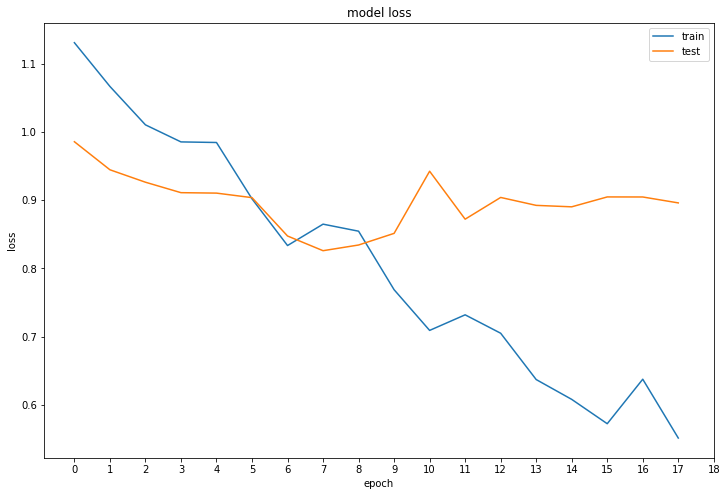

In [ ]:
# #let's plot losses

# history = model.history.history
# # list all data in history
# #print(history.keys())
# # summarize history for accuracy
# plt.figure(figsize = (12,8))
# plt.plot(history['loss'])
# plt.plot(history['val_loss'])

# ticks = list(range(len(history['loss'])+1)) # we need integers in x axis (epochs)
# plt.xticks(ticks)

# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.show()

In [ ]:
## CHECK MODEL ON Test DATA

In [ ]:
# model.load_weights('model.hdf5')

In [ ]:
# predictions = model.predict(X_test)

In [ ]:
# y_pred = predictions.argmax(axis = 1) 
# y_pred.shape

(50,)

In [ ]:
# y_pred

array([2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 2, 1, 2, 2, 2,
       2, 1, 1, 2, 0, 2, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 2, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0])

In [ ]:
# c=y_test.argmax(axis = 1) 

In [ ]:
# c,y_pred=list(c),list(y_pred)

In [ ]:
# cnt=0
# for i in range(len(c)):
#   if c[i]==y_pred[i]:
#     cnt+=1
# cnt/len(y_pred)

0.72

In [ ]:
#"0" for Neurtal, "1" for positive , "2" for negative